<h1>1. Import and setup library, Data structure</h1>

In [141]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd
import math
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

sns.set_style('whitegrid')

<h1>2. Exploring, Preprocessing Dataset</h1>
<h1>2.1 Data Loader, Data visualization and Analysis</h1>
<h1>2.1.1 Create Data loader & view</h1>

In [185]:
class DataLoader:
    def __init__(self, data_path, className = 'class'):
        # Step 1: Load CSV
        self.dataset = pd.read_csv(data_path)
        self.class_items = None
        self.className = className

    def encoding_value(self):
        # Step 2: Encode all attribute values into numeric IDs
        self.item_to_id = {}
        self.id_to_item = {}
        current_index = 0

        # Go column by column
        for col in self.dataset.columns:
            unique_vals = self.dataset[col].unique()
            for val in unique_vals:
                item = f"{col}={val}"
                if item not in self.item_to_id:
                    self.item_to_id[item] = current_index
                    self.id_to_item[current_index] = item
                    current_index += 1

        # Step 3: Replace values in the DataFrame with numeric IDs
        for col in self.dataset.columns:
            self.dataset[col] = self.dataset[col].apply(
                lambda v: self.item_to_id[f"{col}={v}"]
            )
        
        self.class_items = [i for i, item in self.id_to_item.items() if item.startswith(f"{self.className}=")]

    def convert2Transactions(self):
        """Convert the numeric DataFrame rows into list-of-list transactions"""
        transactions = []
        for _, row in self.dataset.iterrows():
            transaction = [int(row[col]) for col in self.dataset.columns]
            transactions.append(transaction)
        self.dataset = transactions


        
myData = DataLoader(className ='diagnosed_diabetes', data_path = '/kaggle/input/diabetes-health-indicators-dataset/diabetes_dataset.csv')#"/kaggle/input/mushroom-classification/mushrooms.csv")
print(f"shape:{myData.dataset.shape}")
# for col in myData.dataset.columns:
#     unique_vals = myData.dataset[col].unique()
#     print(f"{col} ({len(unique_vals)} unique values): {unique_vals}\n")

myData.dataset.info()

shape:(100000, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 100000 non-null  int64  
 1   gender                              100000 non-null  object 
 2   ethnicity                           100000 non-null  object 
 3   education_level                     100000 non-null  object 
 4   income_level                        100000 non-null  object 
 5   employment_status                   100000 non-null  object 
 6   smoking_status                      100000 non-null  object 
 7   alcohol_consumption_per_week        100000 non-null  int64  
 8   physical_activity_minutes_per_week  100000 non-null  int64  
 9   diet_score                          100000 non-null  float64
 10  sleep_hours_per_day                 100000 non-null  float64
 11  screen_t

In [152]:
myData.dataset.head(10).style.set_table_styles(
    [{'selector': 'table', 'props': 'height:300px; overflow:auto; display:block;'}]
)

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.700000,7.900000,7.900000,0,0,0,30.500000,0.890000,134,78,68,239,41,160,145,136,236,6.360000,8.180000,29.600000,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.700000,6.500000,8.700000,0,0,0,23.100000,0.800000,129,76,67,116,55,50,30,93,150,2.000000,5.630000,23.000000,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.400000,10.000000,8.100000,1,0,0,22.200000,0.810000,115,73,74,213,66,99,36,118,195,5.070000,7.510000,44.700000,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.400000,6.600000,5.200000,0,0,0,26.800000,0.880000,120,93,68,171,50,79,140,139,253,5.280000,9.030000,38.200000,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.200000,7.400000,5.000000,0,0,0,21.200000,0.780000,92,67,67,210,52,125,160,137,184,12.740000,7.200000,23.500000,Type 2,1
5,46,Female,White,Highschool,Upper-Middle,Employed,Never,2,124,9.000000,6.200000,5.400000,0,0,0,26.100000,0.850000,95,81,57,218,61,119,179,100,133,8.770000,6.030000,23.500000,Pre-Diabetes,0
6,75,Female,White,Graduate,Upper-Middle,Retired,Never,0,53,9.200000,7.800000,8.000000,0,1,0,25.100000,0.880000,129,77,81,238,46,161,155,101,100,10.140000,5.240000,36.100000,Pre-Diabetes,0
7,62,Male,White,Postgraduate,Middle,Unemployed,Current,1,75,4.100000,9.000000,12.900000,0,1,1,23.900000,0.860000,128,83,76,241,49,159,120,110,189,8.960000,7.040000,34.200000,Type 2,1
8,42,Male,Black,Highschool,Lower-Middle,Employed,Current,1,114,6.700000,8.500000,8.500000,0,0,1,24.700000,0.840000,103,71,72,187,33,132,98,116,172,5.700000,6.900000,26.700000,Type 2,1
9,59,Female,White,Graduate,Middle,Employed,Current,3,86,8.200000,5.300000,7.400000,0,0,0,26.700000,0.810000,124,81,70,188,52,103,104,76,109,4.490000,4.990000,30.000000,No Diabetes,0


<h1>2.1.2 Data visualization and Analysis</h1>

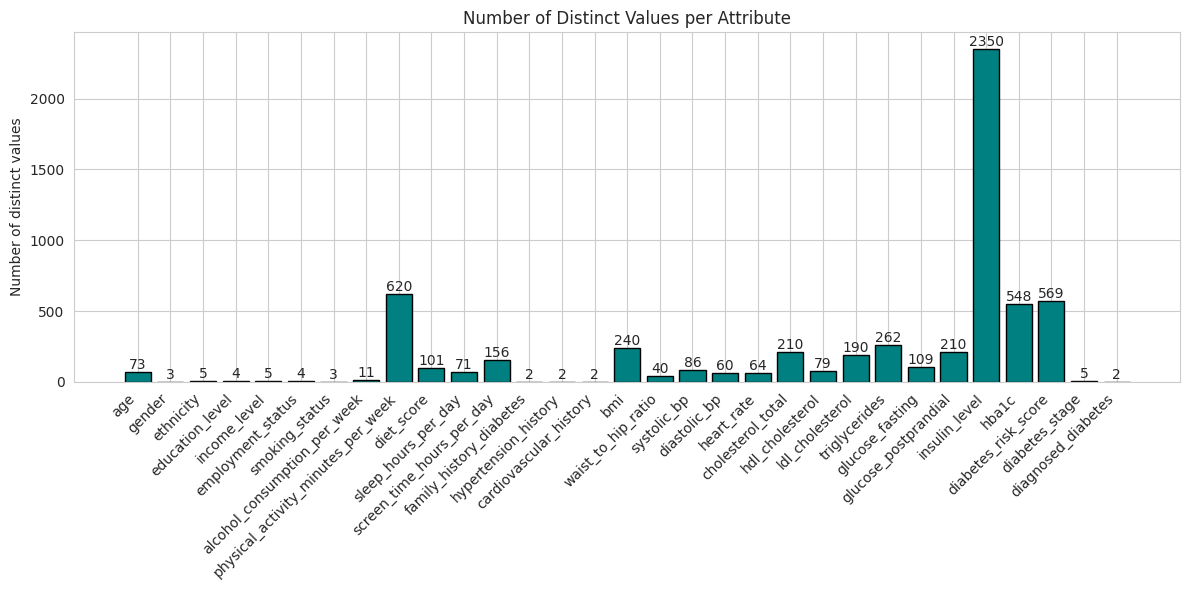

In [158]:
import matplotlib.pyplot as plt

# Count distinct values for each column
distinct_counts = myData.dataset.nunique()

# Plot bar chart
plt.figure(figsize=(12,6))
bars = plt.bar(distinct_counts.index, distinct_counts.values, color="teal", edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of distinct values")
plt.title("Number of Distinct Values per Attribute")

# Add numbers on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, str(height), ha='center', va='bottom')

plt.tight_layout()
plt.show()


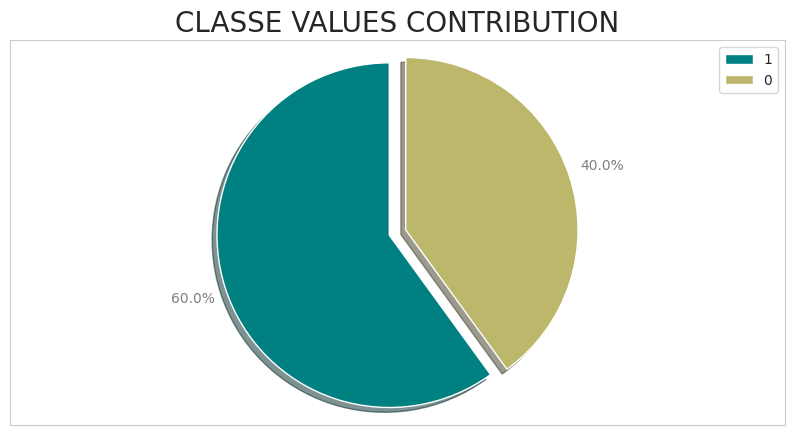

In [153]:
labels = myData.dataset['diagnosed_diabetes'].value_counts().index
sizes = myData.dataset['diagnosed_diabetes'].value_counts().values

plt.figure(figsize=(10,5))
plt.pie(x=sizes,autopct='%1.1f%%',explode=(0.1,0),shadow=True, textprops={'color':"gray"}, 
startangle=90,colors=["teal","darkkhaki"],frame=True,pctdistance=1.2,labeldistance=0)
plt.axis('equal')
plt.legend(labels)
plt.title("Classe values contribution".upper(),fontsize=20)
plt.xticks([])
plt.yticks([])
plt.show()

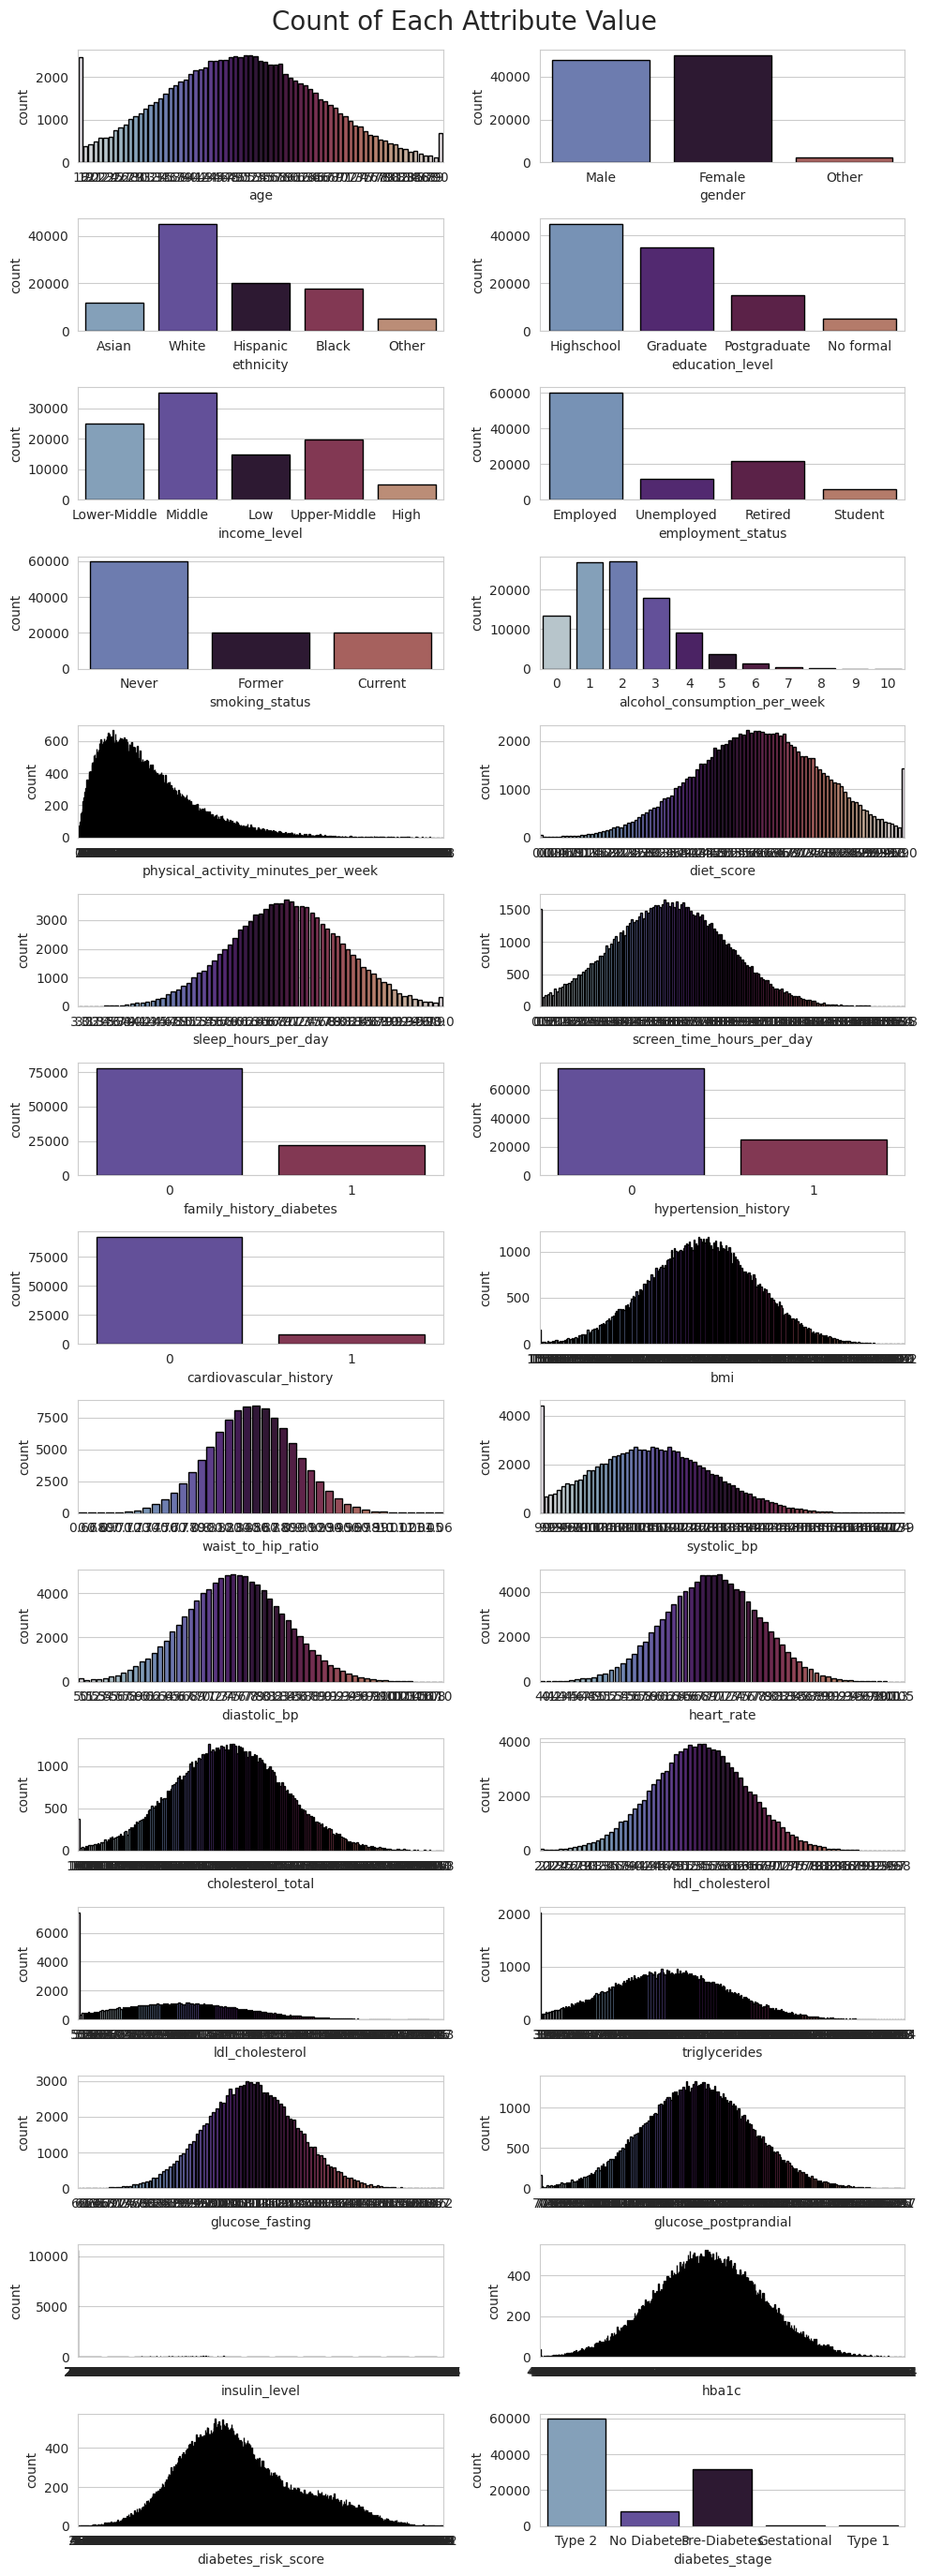

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,28))

num_cols = myData.dataset.shape[1] - 1  # exclude class column
for idx, col in enumerate(myData.dataset.iloc[:, :-1].columns):
    plt.subplot((num_cols + 1) // 2, 2, idx + 1)  # subplot index starts at 1
    sns.countplot(x=col, data=myData.dataset, palette="twilight", edgecolor="black")
    plt.xlabel(col)
    plt.ylabel("count")

plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave space for suptitle
plt.suptitle("Count of Each Attribute Value", fontsize=20)
plt.show()


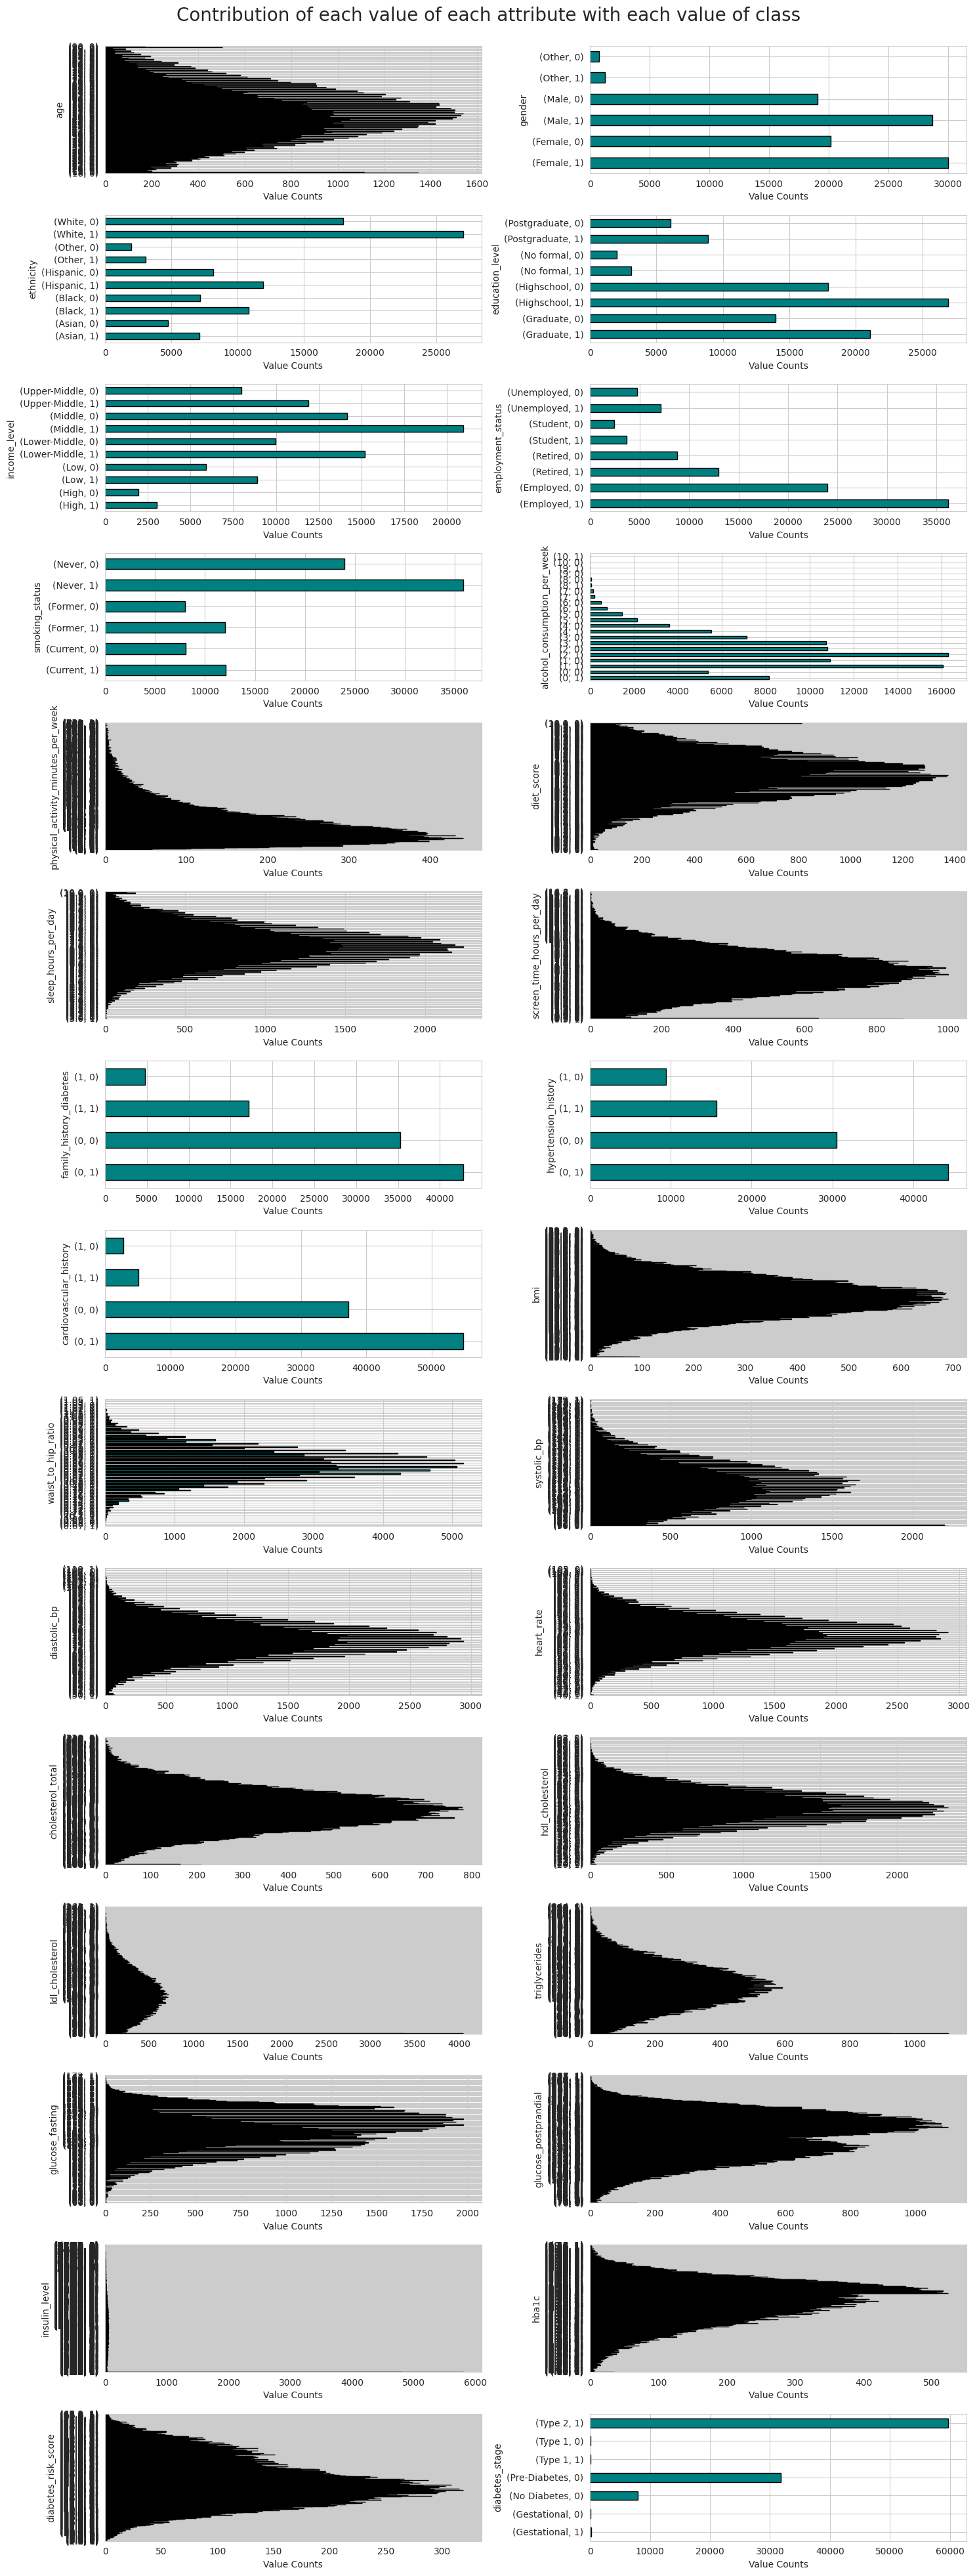

In [195]:
num_cols = myData.dataset.shape[1] - 1 
num_rows = (num_cols + 1) // 2 

plt.figure(figsize=(15, 40))

for idx, col in enumerate(myData.dataset.iloc[:, :-1].columns):
    plt.subplot(num_rows, 2, idx + 1)  # subplot index starts at 1
    myData.dataset.groupby(col)['diagnosed_diabetes'].value_counts().plot(
        kind="barh", edgecolor="black", color="teal"
    )
    plt.xlabel("Value Counts")
    plt.ylabel(col)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Contribution of each value of each attribute with each value of class", fontsize=20)
plt.show()


<h1>2.2 Encoding Value</h1>

In [175]:
myData.encoding_value()
myData.dataset.head(5).style.set_table_styles(
    [{'selector': 'table', 'props': 'height:300px; overflow:auto; display:block;'}]
)

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,0,73,76,81,85,90,94,97,108,728,829,900,1056,1058,1060,1062,1302,1342,1428,1488,1552,1762,1841,2031,2293,2402,2612,4962,5510,6079,6084
1,1,74,77,81,86,90,95,98,109,729,830,901,1056,1058,1060,1063,1303,1343,1429,1489,1553,1763,1842,2032,2294,2403,2613,4963,5511,6080,6085
2,2,73,78,81,86,91,94,98,110,730,831,902,1057,1058,1060,1064,1304,1344,1430,1490,1554,1764,1843,2033,2295,2404,2614,4964,5512,6079,6084
3,3,74,79,81,87,92,94,97,111,731,832,903,1056,1058,1060,1065,1305,1345,1431,1488,1555,1765,1844,2034,2296,2405,2615,4965,5513,6079,6084
4,4,73,77,82,86,92,94,98,112,732,833,904,1056,1058,1060,1066,1306,1346,1432,1489,1556,1766,1845,2035,2297,2406,2616,4966,5514,6079,6084


<h1>2.3 Convert Tabular Dataset to Transactions</h1>

In [176]:
myData.convert2Transactions()
for i in range(5):
    print(f'*Transaction {i+1}: {myData.dataset[i]}\n')
print("Class item IDs:", myData.class_items)


*Transaction 1: [0, 73, 76, 81, 85, 90, 94, 97, 108, 728, 829, 900, 1056, 1058, 1060, 1062, 1302, 1342, 1428, 1488, 1552, 1762, 1841, 2031, 2293, 2402, 2612, 4962, 5510, 6079, 6084]

*Transaction 2: [1, 74, 77, 81, 86, 90, 95, 98, 109, 729, 830, 901, 1056, 1058, 1060, 1063, 1303, 1343, 1429, 1489, 1553, 1763, 1842, 2032, 2294, 2403, 2613, 4963, 5511, 6080, 6085]

*Transaction 3: [2, 73, 78, 81, 86, 91, 94, 98, 110, 730, 831, 902, 1057, 1058, 1060, 1064, 1304, 1344, 1430, 1490, 1554, 1764, 1843, 2033, 2295, 2404, 2614, 4964, 5512, 6079, 6084]

*Transaction 4: [3, 74, 79, 81, 87, 92, 94, 97, 111, 731, 832, 903, 1056, 1058, 1060, 1065, 1305, 1345, 1431, 1488, 1555, 1765, 1844, 2034, 2296, 2405, 2615, 4965, 5513, 6079, 6084]

*Transaction 5: [4, 73, 77, 82, 86, 92, 94, 98, 112, 732, 833, 904, 1056, 1058, 1060, 1066, 1306, 1346, 1432, 1489, 1556, 1766, 1845, 2035, 2297, 2406, 2616, 4966, 5514, 6079, 6084]

Class item IDs: [6084, 6085]


<h1>3.Model</h1>
<h1>3.1 Rule Extraction(Associative Rules)</h1>

In [177]:
from typing import List, Dict, Tuple, Set
import math
from itertools import combinations

Transaction = List[int]
Itemset = Tuple[int, ...]

class AssociativeRuleGeneration:
    def __init__(self, class_items: Set[int], minsup_percent: float = 0.1, min_conf: float = 0.5):
        self.class_items = class_items
        self.minsup_percent = minsup_percent  # 0.1 = 10%
        self.min_conf = min_conf
        self.rules: List[Tuple[Set[int], Set[int], float, float]] = []

    # ---------- Frequent Itemsets ----------
    def find_f1_itemsets(self, T: List[Transaction], min_cnt: int) -> Dict[Itemset, int]:
        counts: Dict[int, int] = {}
        for t in T:
            for it in t:
                counts[it] = counts.get(it, 0) + 1
        L1: Dict[Itemset, int] = {}
        for it, c in counts.items():
            if c >= min_cnt:
                L1[(it,)] = c
        return L1

    def notPruneIf_has_all_k_subsets_in_Lk(self, c, Lk):
        for idx in range(len(c)):
            subset = c[:idx] + c[idx + 1:]
            if subset not in Lk:
                return False
        return True

    def aprioriGeneration(self, Lk, k):
        candidates = {}
        keys = sorted(Lk.keys())
        for a in keys:
            for b in keys:
                if a[:k-1] == b[:k-1] and a[k-1] < b[k-1]:
                    c = a + (b[k-1],)
                    if not any(it in self.class_items for it in c):
                        continue
                    if self.notPruneIf_has_all_k_subsets_in_Lk(c, Lk):
                        candidates[c] = 0
        return candidates

    def count_supports(self, T, candidates):
        if not candidates:
            return candidates
        k = len(next(iter(candidates.keys())))
        cand_keys = set(candidates.keys())
        for t in T:
            if len(t) < k:
                continue
            sorted_t = tuple(sorted(t))
            for s in combinations(sorted_t, k):
                if s in cand_keys:
                    candidates[s] += 1
        return candidates

    def apriori_algorithm(self, T: List[Transaction]) -> Dict[Itemset, int]:
        n_tx = len(T)
        min_cnt = int(math.ceil(self.minsup_percent * n_tx))
        Lk = self.find_f1_itemsets(T, min_cnt)
        all_frequents = dict(Lk)
        k = 1

        while Lk:
            Ckplus1 = self.aprioriGeneration(Lk, k)
            Ckplus1 = self.count_supports(T, Ckplus1)
            LkPlus1 = {iset: cnt for iset, cnt in Ckplus1.items() if cnt >= min_cnt}
            all_frequents.update(LkPlus1)
            Lk = LkPlus1
            k += 1
        return all_frequents

    # ---------- Rules ----------
    def generate_rules(self, frequents: Dict[Itemset, int], T: List[Transaction]):
        n_tx = len(T)
        supports = {itemset: count / n_tx for itemset, count in frequents.items()}
        rules = []

        for itemset in frequents.keys():
            if len(itemset) < 2:
                continue
            for i in range(1, len(itemset)):
                for antecedent in combinations(itemset, i):
                    antecedent = set(antecedent)
                    consequent = set(itemset) - antecedent
                    if not consequent:
                        continue
                    sup_XY = supports[itemset]
                    sup_X = supports.get(tuple(sorted(antecedent)), None)
                    if sup_X:
                        conf = sup_XY / sup_X
                        if conf >= self.min_conf:
                            rules.append((antecedent, consequent, sup_XY, conf))
        return rules

    def filter_class_rules(self, rules):
        return [r for r in rules if any(it in self.class_items for it in r[1])]

    # ---------- Run ----------
    def run(self, T: List[Transaction]):
        frequents = self.apriori_algorithm(T)
        rules = self.generate_rules(frequents, T)
        class_rules = self.filter_class_rules(rules)
        self.rules = class_rules
        return class_rules

assoc = AssociativeRuleGeneration(myData.class_items)
assoc.run(myData.dataset)

print(f"\nFound {len(assoc.rules)} rules predicting class:")
for antecedent, consequent, sup, conf in assoc.rules:
    readable_ant = [myData.id_to_item[i] for i in antecedent]
    readable_con = [myData.id_to_item[i] for i in consequent]
    print(f"{readable_ant} -> {readable_con} (support={sup:.3f}, confidence={conf:.3f})")



Found 25 rules predicting class:
['gender=Male'] -> ['diagnosed_diabetes=1'] (support=0.287, confidence=0.601)
['gender=Female'] -> ['diagnosed_diabetes=1'] (support=0.301, confidence=0.598)
['ethnicity=White'] -> ['diagnosed_diabetes=1'] (support=0.270, confidence=0.601)
['ethnicity=Hispanic'] -> ['diagnosed_diabetes=1'] (support=0.119, confidence=0.594)
['ethnicity=Black'] -> ['diagnosed_diabetes=1'] (support=0.108, confidence=0.601)
['education_level=Highschool'] -> ['diagnosed_diabetes=1'] (support=0.270, confidence=0.601)
['education_level=Graduate'] -> ['diagnosed_diabetes=1'] (support=0.211, confidence=0.601)
['income_level=Lower-Middle'] -> ['diagnosed_diabetes=1'] (support=0.152, confidence=0.604)
['income_level=Middle'] -> ['diagnosed_diabetes=1'] (support=0.210, confidence=0.597)
['income_level=Upper-Middle'] -> ['diagnosed_diabetes=1'] (support=0.119, confidence=0.599)
['employment_status=Employed'] -> ['diagnosed_diabetes=1'] (support=0.362, confidence=0.602)
['employment

<h1 style="text-align: center;">End Project</h1>